In [5]:
import torch
from models import MotionTransformer
from utils.get_opt import get_opt
import numpy as np
from os.path import join as pjoin
from trainers import DDPMTrainer

encoder = MotionTransformer(
        input_feats=264,
        num_frames=360,
        num_layers=8,
        latent_dim=512,
        no_clip=False,
        no_eff=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/opt.txt"
opt = get_opt(opt_path, device)
opt.do_denoise = True

mean = np.load(pjoin(opt.meta_dir, 'mean.npy'))
std = np.load(pjoin(opt.meta_dir, 'std.npy'))
trainer = DDPMTrainer(opt, encoder)
trainer.load(pjoin(opt.model_dir, opt.which_epoch + '.tar'))

trainer.eval_mode()
trainer.to(opt.device)

result_dict = {}
with torch.no_grad():
        caption = ["the first thing i like to do on weekends is relaxing and i'll go shopping if i'm not that tired"]
        m_lens = torch.LongTensor([360]).to(device)
        pred_motions = trainer.generate(caption, m_lens, 264)
        motion = pred_motions[0].cpu().numpy()
        print(motion.shape)
opt.result_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints"
np.save(pjoin(opt.result_dir, 'motion_15.npy'), motion)

Reading /home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/opt.txt


100%|██████████| 1000/1000 [00:21<00:00, 45.67it/s]

(360, 264)


✅ Imports successful!

🔨 Creating pipeline from scratch...
   Fitting on BVH sample: 1_wayne_0_1_1.bvh
   ✅ Pipeline fitted (structure learned)

📥 Loading Mean/Std from Meta files...
   ✅ Đã tìm thấy Mean và Std từ file .npy
   Shape của Mean: (264,)
   Shape của Std: (264,)
   Mean (5 giá trị đầu): [0.01007969 0.00226879 0.01035749 0.01484728 0.00253134]

🔧 Overriding pipeline statistics with meta values...
   ✅ Pipeline updated with meta statistics!

🎬 Visualizing: motion_15.npy
   Motion shape: (360, 264)
   Performing inverse transform...
positions 2 eulers is not supported
   ✅ Reconstructed shape: (360, 264)

   Creating 2D visualization...


<Figure size 1000x800 with 0 Axes>

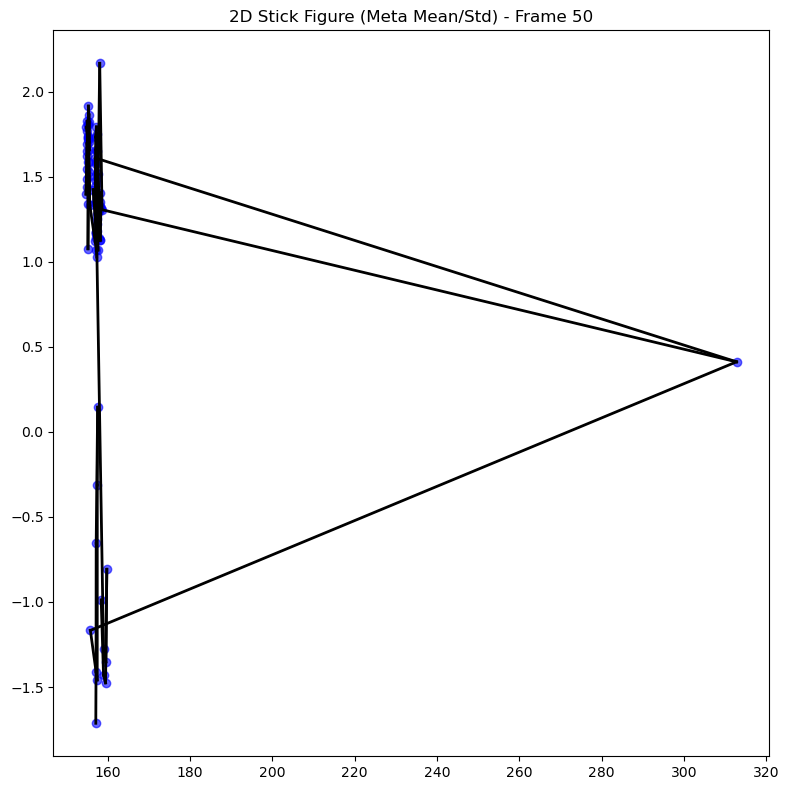


   Creating 3D visualization...


<Figure size 1000x800 with 0 Axes>

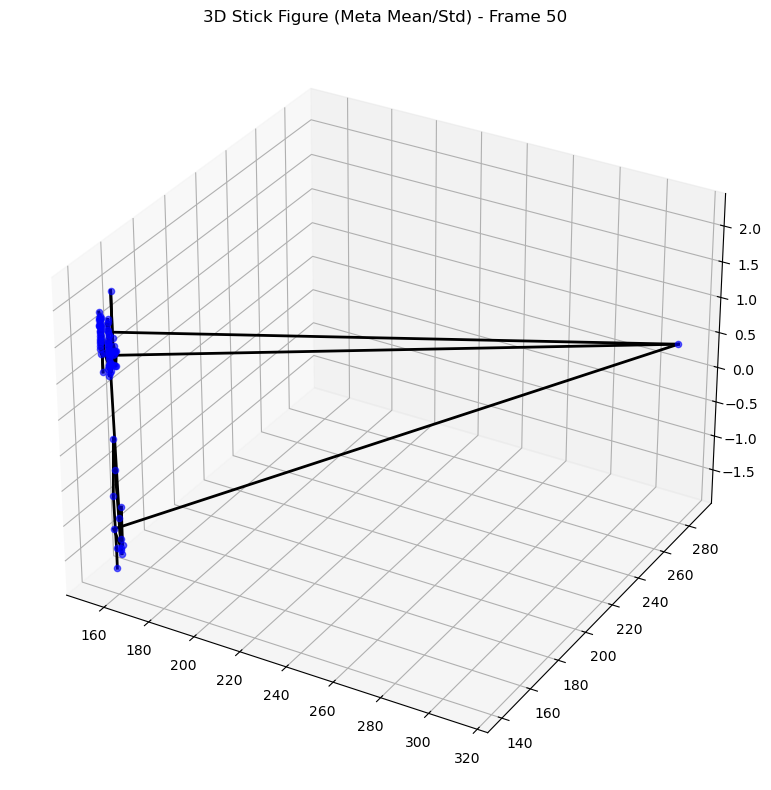

   ✅ Done!


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

# ===== 1. CREATE PIPELINE WITH META =====
print("\n🔨 Creating pipeline from scratch...")

pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

# ===== 2. FIT PIPELINE (Structure Learning) =====
# Cần fit vào một file BVH mẫu để pipeline học được cấu trúc xương (skeleton)
bvh_sample_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/BEAT/1/1_wayne_0_1_1.bvh"
print(f"   Fitting on BVH sample: {os.path.basename(bvh_sample_path)}")

if os.path.exists(bvh_sample_path):
    parser = BVHParser()
    parsed_data = parser.parse(bvh_sample_path)
    pipeline.fit([parsed_data])
    print("   ✅ Pipeline fitted (structure learned)")
else:
    print(f"❌ Error: BVH file not found at {bvh_sample_path}")
    sys.exit(1)

# ===== 3. LOAD MEAN/STD FROM META (.npy files) =====
meta_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/meta"
mean_path = os.path.join(meta_dir, "mean.npy")
std_path = os.path.join(meta_dir, "std.npy")

print("\n📥 Loading Mean/Std from Meta files...")
try:
    # Load trực tiếp từ file .npy
    mean = np.load(mean_path)
    std = np.load(std_path)

    print("   ✅ Đã tìm thấy Mean và Std từ file .npy")
    print(f"   Shape của Mean: {mean.shape}")
    print(f"   Shape của Std: {std.shape}")
    
    # In thử vài giá trị đầu để kiểm tra
    print(f"   Mean (5 giá trị đầu): {mean[:5]}")
    
    # Override pipeline statistics
    print("\n🔧 Overriding pipeline statistics with meta values...")
    pipeline.named_steps['stdscale'].data_mean_ = mean
    pipeline.named_steps['stdscale'].data_std_ = std
    print("   ✅ Pipeline updated with meta statistics!")

except Exception as e:
    print(f"❌ Có lỗi xảy ra khi load meta: {e}")
    # Nếu không có mean/std thì visualization sẽ bị sai, nên dừng hoặc cảnh báo
    sys.exit(1)

# ===== 4. VISUALIZE MOTION =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/motion_15.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")

if os.path.exists(npy_path):
    # Load motion data
    motion_data = np.load(npy_path)
    print(f"   Motion shape: {motion_data.shape}")

    # Inverse transform
    print("   Performing inverse transform...")
    # Lưu ý: inverse_transform trả về list các object MocapData
    reconstructed = pipeline.inverse_transform([motion_data])
    print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

    # Visualize 2D
    print("\n   Creating 2D visualization...")
    fig1 = plt.figure(figsize=(10, 8))
    draw_stickfigure(reconstructed[0], frame=frame)
    plt.title(f"2D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()

    # Visualize 3D
    print("\n   Creating 3D visualization...")
    fig2 = plt.figure(figsize=(10, 8))
    draw_stickfigure3d(reconstructed[0], frame=frame)
    plt.title(f"3D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()
    
    print("   ✅ Done!")
else:
    print(f"❌ Error: Motion file not found at {npy_path}")